# Домашняя работа 2 · Преобразование таргета и классические модели

## План ноутбука
1. Загрузка данных и проверка структуры — количество строк, сегментов, диапазон дат.
2. Наивный прогноз vs STL-декомпозиция + наивный прогноз — сравнение SMAPE.
3. Стандартизация таргета (макро vs микро) + линейная регрессия с календарными и Фурье-признаками.
4. Подбор гиперпараметров AutoARIMA для достижения целевого AIC.
5. Обучение Prophet-модели и оценка качества.
6. Финальная модель для сабмита — используйте лучший подход из предыдущих задач.

In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd

import warnings
import logging

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)


from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import AutoARIMAModel, LinearMultiSegmentModel, NaiveModel
from etna.pipeline import Pipeline
from etna.transforms import (
    AddConstTransform,
    BoxCoxTransform,
    DateFlagsTransform,
    FilterFeaturesTransform,
    FourierTransform,
    STLTransform,
)

HORIZON = 366
METRIC = SMAPE()

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:35: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:49: UserWarning: etna[chronos] is not available, to install it, run `pip install etna[chronos]`
  warnings.warn("etna[chronos] is not available, to install it, run `pip install etna[chronos]`")
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:64: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:72: UserWarning: wandb is not available, to install it, run `p

In [2]:
def evaluate_pipeline(pipeline: Pipeline, ts: TSDataset) -> float:
    '''Запускаем один фолд backtest и возвращаем средний SMAPE по всем сегментам.'''
    backtest_output = pipeline.backtest(ts=ts, metrics=[METRIC], n_folds=1)
    fold_mean = backtest_output["metrics"].groupby("fold_number")["SMAPE"].mean().iloc[0]
    return fold_mean

## 1. Загрузка данных и sanity-check
**Что сделать:** 
- прочитать parquet-файл
- убедиться в количестве строк/сегментов и границах дат
- нарисовать несколько рядов


In [3]:
from etna.datasets import TSDataset

DATA_PATH = "https://gist.githubusercontent.com/martins0n/86ca7e632a57bb1faefa98dc8e467d17/raw/2dfa5e6acf97ae2f6a587fc5e1c629836a8af16b/train.parquet"
raw_df = pd.read_parquet(DATA_PATH)
ts = TSDataset(df=raw_df.copy(), freq="D")

raw_df.head()

,segment,timestamp,target,country,store,product
0,Canada-TechWave-EchoWatch,2010-01-01,487.0,Canada,TechWave,EchoWatch
1,Canada-TechWave-ProTab,2010-01-01,454.0,Canada,TechWave,ProTab
2,Canada-TechWave-CoreX360,2010-01-01,212.0,Canada,TechWave,CoreX360
3,Canada-TechWave-ShadowX,2010-01-01,246.0,Canada,TechWave,ShadowX
4,Canada-GadgetOutlet-QuantumPhone,2010-01-01,149.0,Canada,Gadget Outlet,QuantumPhone


In [4]:
rows = 192808 # Количество строк в raw_df
segments = 88 # Количество уникальных сегментов в ts
start_year = 2010 # Год минимальной даты
end_year = 2015 # Год максимальной даты

In [5]:
# Не редактируй этот блок кода, он нужен для автоматической проверки

summary = {
    "rows": rows, # 192808
    "segments": segments, # 88
    "start_year": start_year, # "2010"
    "end_year": end_year # "2015"
}
print(json.dumps(summary))

{"rows": 192808, "segments": 88, "start_year": 2010, "end_year": 2015}


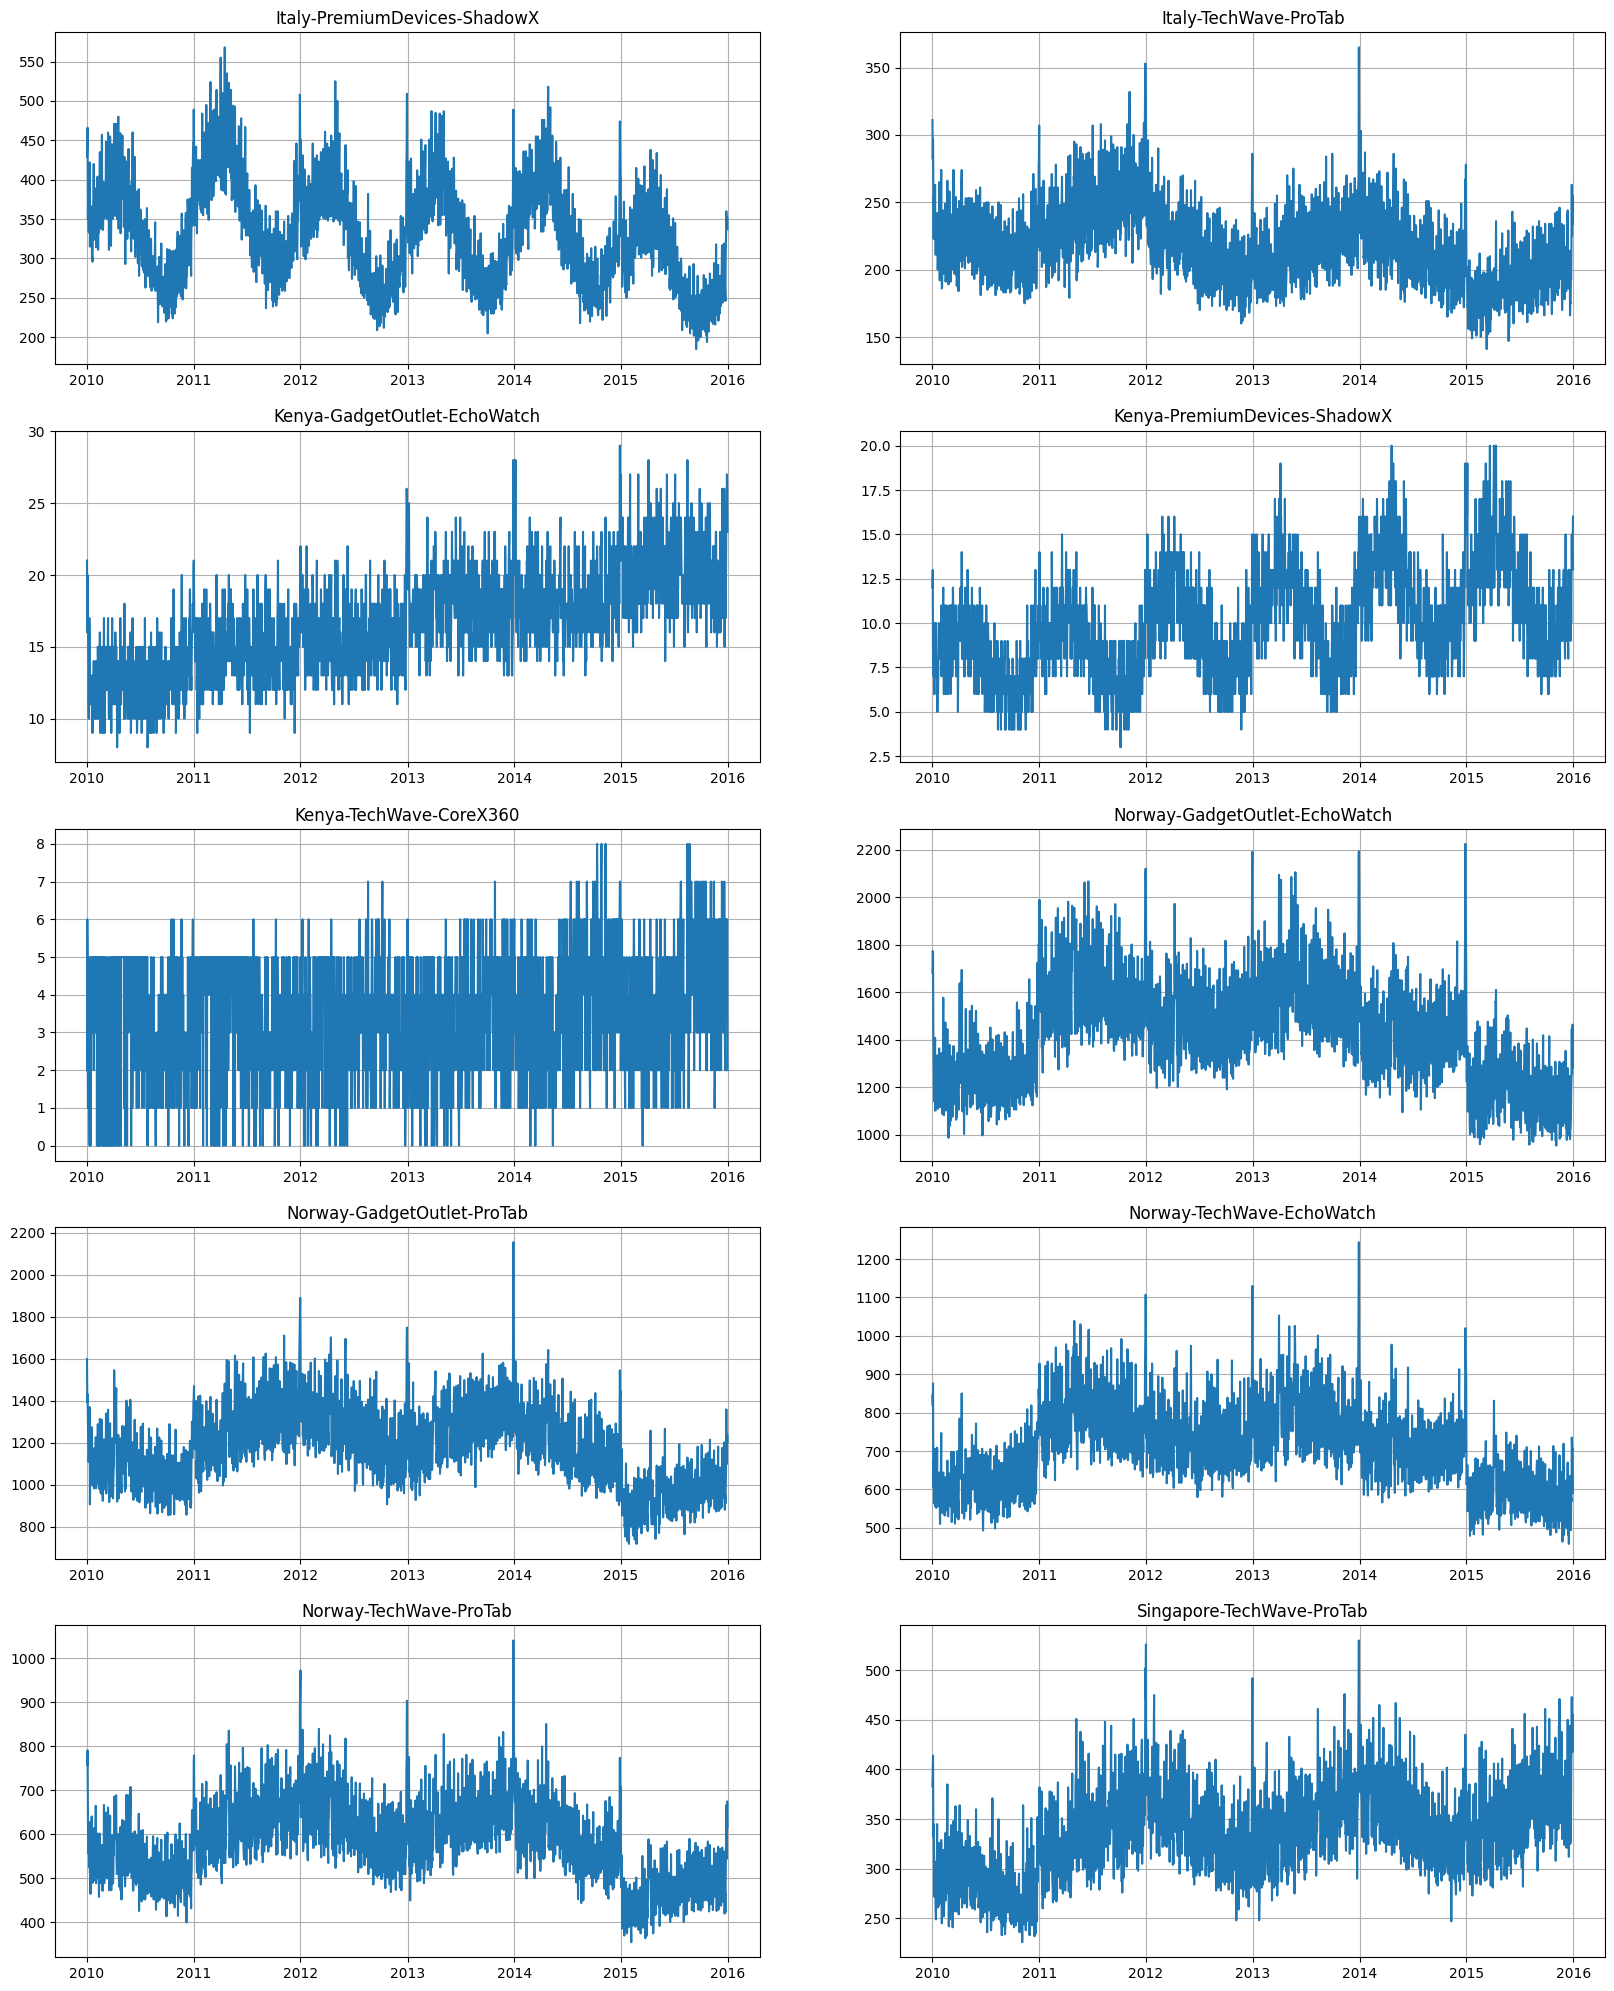

In [6]:
# Быстрый просмотр нескольких сегментов, чтобы понять динамику.
ts.plot()

## 2. Наивный baseline против STL + Naive
**Что сделать:** собрать два пайплайна с одинаковым горизонтом (366 дней):
- чисто наивная модель `NaiveModel(lag=HORIZON)`;
- такая же модель, но после `STLTransform`, который вычитает тренд и сезонность.
Затем посчитать SMAPE через backtest и сравнить результаты.

In [7]:
import json
from etna.models import NaiveModel
from etna.transforms import STLTransform, FilterFeaturesTransform
from etna.pipeline import Pipeline

import numpy as np
import random


np.random.seed(2025)
random.seed(2025)

# TODO: Create naive_pipeline using NaiveModel with lag=HORIZON
naive_pipeline = Pipeline(
    model=NaiveModel(lag=HORIZON),
    transforms=[FilterFeaturesTransform(exclude=["country", "store", "product"])],
    horizon=HORIZON
)

naive_smape = evaluate_pipeline(naive_pipeline, ts=ts)

# TODO: Create stl_pipeline using STLTransform + NaiveModel
# Hint: Use STLTransform(in_column="target", period=HORIZON, model="arima")
stl_pipeline = Pipeline(
    model=NaiveModel(lag=HORIZON),
    transforms=[
        STLTransform(in_column="target", period=HORIZON, model="arima"),
        FilterFeaturesTransform(exclude=["country", "store", "product"])
    ],
    horizon=HORIZON
)

stl_smape = evaluate_pipeline(stl_pipeline, ts=ts)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [8]:
# Не редактируй этот блок кода, он нужен для автоматической проверки

result = {
        "naive_smape": naive_smape, # <21
        "stl_naive_smape": stl_smape, # <21
        "stl_improves": bool(stl_smape < naive_smape), # True
}

print(json.dumps(result))

{"naive_smape": 20.164902697960898, "stl_naive_smape": 20.056612429290873, "stl_improves": true}


## 3. Стандартизация и линейная регрессия на всех сегментах
**Что сделать:** проверьте, что корректная стандартизация таргета (макро- или микро-стандартизация) улучшает качество линейной регрессии обученной на всех сегментах `LinearMultiSegmentModel`. В качестве признаков используйте календарные и Фурье-признаки.

In [9]:
import json
from etna.models import LinearMultiSegmentModel
from etna.transforms import StandardScalerTransform, DateFlagsTransform, FourierTransform
from etna.pipeline import Pipeline

# TODO: Create macro_transforms list with:
#   - StandardScalerTransform
#   - DateFlagsTransform with calendar features (day_number_in_week, day_number_in_month, etc.)
#   - FourierTransform for weekly seasonality
#   - FourierTransform for yearly seasonality
macro_transforms = [
    StandardScalerTransform(in_column="target", mode="macro"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        week_number_in_month=True,
        week_number_in_year=True,
        month_number_in_year=True,
        season_number=True,
        is_weekend=True
    ),
    FourierTransform(period=7, order=2, out_column="fourier_weekly"),
    FourierTransform(period=365.25, order=2, out_column="fourier_yearly")
]

# TODO: Create macro_pipeline with LinearMultiSegmentModel, macro_transforms, and HORIZON
macro_pipeline = Pipeline(
    model=LinearMultiSegmentModel(),
    transforms=macro_transforms,
    horizon=HORIZON
)

macro_lr_smape = evaluate_pipeline(macro_pipeline, ts=ts)

# TODO: Create micro_transforms list with:
#   - StandardScalerTransform
#   - Same DateFlagsTransform and FourierTransform as above
micro_transforms = [
    StandardScalerTransform(in_column="target", mode="per-segment"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        week_number_in_month=True,
        week_number_in_year=True,
        month_number_in_year=True,
        season_number=True,
        is_weekend=True
    ),
    FourierTransform(period=7, order=2, out_column="fourier_weekly"),
    FourierTransform(period=365.25, order=2, out_column="fourier_yearly")
]

# TODO: Create micro_pipeline with LinearMultiSegmentModel, micro_transforms, and HORIZON
micro_pipeline = Pipeline(
    model=LinearMultiSegmentModel(),
    transforms=micro_transforms,
    horizon=HORIZON
)

micro_lr_smape = evaluate_pipeline(micro_pipeline, ts=ts)

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\models\sklearn.py:27: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['country', 'product', 'store'] won't be used.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\models\sklearn.py:27: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['country', 'product', 'store'] won't be used.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done   1 out of   

In [10]:
# Не редактируй этот блок кода, он нужен для автоматической проверки

result = {
        "is_per_segment_better": bool(micro_lr_smape < macro_lr_smape), # True
        "micro_lr_smape": micro_lr_smape, # < 22
}


print(json.dumps(result))

{"is_per_segment_better": true, "micro_lr_smape": 21.562878519408073}


## 4. AutoARIMA с подбором гиперпараметров
**Что сделать:** подберите параметры для `AutoARIMAModel` из ETNA так, чтобы получить AIC меньше порогового значения (см. комментарий в коде).

In [11]:
import json
from etna.models import AutoARIMAModel
from etna.datasets import TSDataset

# Select just ONE segment for performance
segment_name = 'Canada-GadgetOutlet-CoreX360'
single_segment_df = ts[:, segment_name, :]
single_segment_ts = TSDataset(df=single_segment_df, freq="D")

# TODO: Define kwargs dictionary with AutoARIMA hyperparameters
# Hint: Experiment with parameters like:
#   - start_p, start_q, max_p, max_q (non-seasonal orders)
#   - seasonal=True/False
#   - m (seasonal period)
#   - start_P, start_Q, max_P, max_Q (seasonal orders)
#   - d, D (differencing orders)
#   - and others from AutoARIMAModel documentation

kwargs = {
    "start_p": 0,
    "start_q": 0,
    "max_p": 3,
    "max_q": 3,
    "seasonal": True,
    "m": 7,  # weekly seasonality
    "start_P": 0,
    "start_Q": 0,
    "max_P": 2,
    "max_Q": 2,
    "d": None,  # auto-detect
    "D": None,  # auto-detect
    "stepwise": True,
    "suppress_warnings": True
}

autoarima_model = AutoARIMAModel(**kwargs)
autoarima_model.fit(ts=single_segment_ts)
internal_models = autoarima_model.get_model()

aic = internal_models[segment_name].aic

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\models\sarimax.py:214: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['country', 'product', 'store'] won't be used.
  warnings.warn(


In [12]:
# Не редактируй этот блок кода, он нужен для автоматической проверки

result = {
        "segment_name": segment_name, # Canada-GadgetOutlet-CoreX360
        "aic": aic # <20000
}

print(json.dumps(result))

{"segment_name": "Canada-GadgetOutlet-CoreX360", "aic": 19585.483516191045}


Посмотрим подробнее на диагностику Аримы. Что здесь можно увидеть?

In [13]:
internal_models[segment_name].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2191
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9785.742
Date:                             Fri, 05 Dec 2025   AIC                          19585.484
Time:                                     22:40:49   BIC                          19625.325
Sample:                                          0   HQIC                         19600.045
                                            - 2191                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.029e-05      0.001     -0.092      0.927      -0.002       0.001
ar.L1          0.7725      0.101      7.619      0.000       0.574       0.971
ma.L1         -1.4665      0.108    -13.528      0.000      -1.679      -1.254
ma.L2          0.5157      0.083      6.191      0.000       0.352       0.679
ar.S.L7        0.9977      0.001   1055.328      0.000       0.996       1.000
ma.S.L7       -0.9298      0.010    -94.393      0.000      -0.949      -0.910
sigma2       441.0327     10.971     40.199      0.000     419.529     462.536
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               149.47
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.17
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5. Prophet-бейзлайн
**Что сделать:** запустить Prophet и посмотрите на его компоненты.

In [14]:
import json
from etna.models import ProphetModel
from etna.transforms import FilterFeaturesTransform
from etna.pipeline import Pipeline

# TODO: Create ProphetModel instance
model = ProphetModel()

# TODO: Define transforms list (can be empty or include preprocessing transforms)
transforms = [FilterFeaturesTransform(exclude=["country", "store", "product"])]

# TODO: Create prophet_pipeline with model, transforms, and HORIZON
prophet_pipeline = Pipeline(
    model=model,
    transforms=transforms,
    horizon=HORIZON
)

prophet_pipeline_smape = evaluate_pipeline(
    prophet_pipeline, ts=ts
)


22:41:06 - cmdstanpy - INFO - Chain [1] start processing
22:41:08 - cmdstanpy - INFO - Chain [1] done processing
22:41:09 - cmdstanpy - INFO - Chain [1] start processing
22:41:10 - cmdstanpy - INFO - Chain [1] done processing
22:41:10 - cmdstanpy - INFO - Chain [1] start processing
22:41:11 - cmdstanpy - INFO - Chain [1] done processing
22:41:11 - cmdstanpy - INFO - Chain [1] start processing
22:41:12 - cmdstanpy - INFO - Chain [1] done processing
22:41:12 - cmdstanpy - INFO - Chain [1] start processing
22:41:13 - cmdstanpy - INFO - Chain [1] done processing
22:41:13 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:15 - cmdstanpy - INFO - Chain [1] done processing
22:41:15 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing
22:41:17 - cmdstanpy - INFO - Chain [1] start processing
22:41:17 - cmdstanpy - INFO - Chain [1]

In [15]:
# Не редактируй этот блок кода, он нужен для автоматической проверки


result = {
    "prophet_smape": prophet_pipeline_smape, # <17.25
}

print(json.dumps(result))

{"prophet_smape": 17.069386761505367}


Посмотрим на компоненты построенного Prophet-модели для одного из сегментов:

In [16]:
segment_name = 'Canada-GadgetOutlet-CoreX360'

single_segment_df = ts[:, segment_name, :]
single_segment_ts = TSDataset(df=single_segment_df, freq="D")

forecast_prophet = prophet_pipeline.backtest(
    ts=single_segment_ts,
    metrics=[METRIC],
    n_folds=1,
    forecast_params={"return_components": True}
)

22:43:02 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


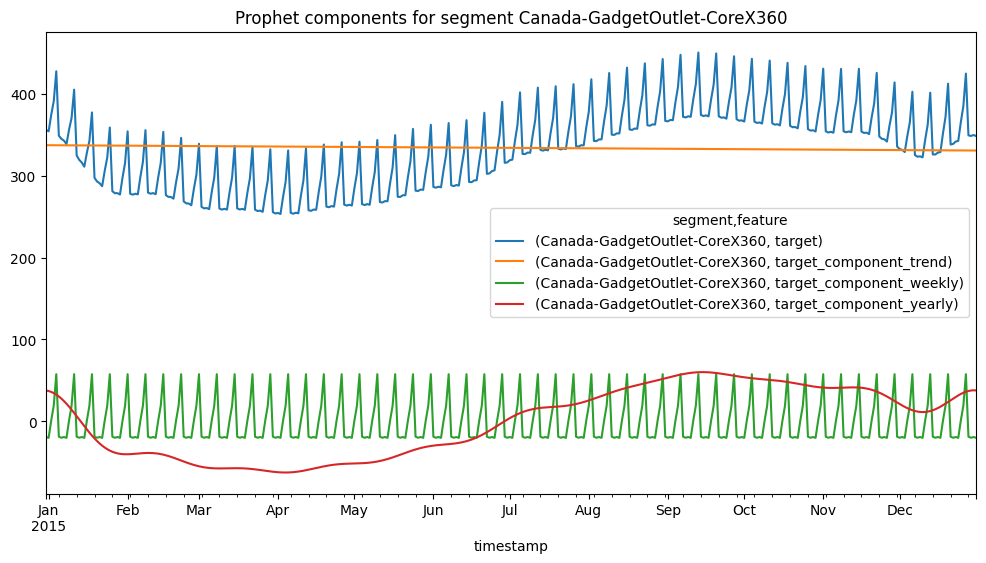

In [17]:
forecast_prophet['forecasts'][0].to_pandas().iloc[:, -4:].plot(figsize=(12, 6))
_ = plt.title(f"Prophet components for segment {segment_name}")

# 6. Сделайте финальный сабмит в kaggle

In [ ]:
import json
from etna.models import ProphetModel
from etna.transforms import FilterFeaturesTransform
from etna.pipeline import Pipeline

# TODO: Create ProphetModel instance
model = ProphetModel()

# TODO: Define transforms list (can be empty or include preprocessing transforms)
transforms = [
    FilterFeaturesTransform(exclude=["country", "store", "product"]),

    # календарные признаки
    DateFlagsTransform(day_number_in_week=True,
                       week_number_in_year=True,
                       day_number_in_month=True,
                       month_number_in_year=True),

    # сильная сезонность → фурье
    FourierTransform(period=365.25, order=5),
]

prophet_pipeline = Pipeline(
    model=model,
    transforms=transforms,
    horizon=HORIZON
)

current_smape = evaluate_pipeline(
    prophet_pipeline, ts=ts
)

23:18:12 - cmdstanpy - INFO - Chain [1] start processing
23:18:13 - cmdstanpy - INFO - Chain [1] done processing
23:18:13 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing
23:18:14 - cmdstanpy - INFO - Chain [1] start processing
23:18:15 - cmdstanpy - INFO - Chain [1] done processing
23:18:15 - cmdstanpy - INFO - Chain [1] start processing
23:18:15 - cmdstanpy - INFO - Chain [1] done processing
23:18:15 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:17 - cmdstanpy - INFO - Chain [1] done processing
23:18:17 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing
23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1]

In [21]:
# Не редактируй этот блок кода, он нужен для автоматической проверки

result = {
    "current_smape": current_smape # <17.0
}

print(json.dumps(result))

{"current_smape": 16.97003191473395}


In [25]:
# Ваш код для финального сабмита в kaggle ниже.

KEY_FOR_KAGGLE_SUB = "https://gist.githubusercontent.com/martins0n/86ca7e632a57bb1faefa98dc8e467d17/raw/78d9024a09d3eaa57129a57d0f96610c1d80e0d7/key_for_submission.csv"

prophet_pipeline.fit(ts)
forecast_ts = prophet_pipeline.forecast(ts)
forecast_df = forecast_ts.to_pandas(flatten=True)

df_submission_example = pd.read_csv(KEY_FOR_KAGGLE_SUB)
df_submission_example["timestamp"] = df_submission_example["timestamp"].apply(pd.to_datetime)

assert len(forecast_df) == len(df_submission_example)

df_submission = df_submission_example.merge(
    forecast_df[["segment", "timestamp", "target"]],
    on=["segment", "timestamp"]
)[["id", "target"]]
df_submission.to_csv("submission_Prophet.csv", index=False)

23:25:25 - cmdstanpy - INFO - Chain [1] start processing
23:25:26 - cmdstanpy - INFO - Chain [1] done processing
23:25:26 - cmdstanpy - INFO - Chain [1] start processing
23:25:27 - cmdstanpy - INFO - Chain [1] done processing
23:25:27 - cmdstanpy - INFO - Chain [1] start processing
23:25:28 - cmdstanpy - INFO - Chain [1] done processing
23:25:28 - cmdstanpy - INFO - Chain [1] start processing
23:25:28 - cmdstanpy - INFO - Chain [1] done processing
23:25:29 - cmdstanpy - INFO - Chain [1] start processing
23:25:29 - cmdstanpy - INFO - Chain [1] done processing
23:25:29 - cmdstanpy - INFO - Chain [1] start processing
23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing
23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:32 - cmdstanpy - INFO - Chain [1] done processing
23:25:32 - cmdstanpy - INFO - Chain [1] start processing
23:25:32 - cmdstanpy - INFO - Chain [1]